## Fitting a Gaussian

1. Fitting a double Gaussian profile to data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import ascii
from scipy.optimize import curve_fit
from astropy.io import fits

In [2]:
def gaussian(x,*p):
    # A gaussian peak with:
    #   Peak height above background : p[0]
    #   Central value                : p[1]
    #   Standard deviation           : p[2]
    # This model assumes the background level is zero
    
    return p[0]*np.exp(-1.*(x-p[1])**2/(2.*p[2]**2))

In [3]:
def gaussian_onepeak(x,*p):
    # A gaussian peak with:
    #   Peak height above background : p[0]
    #   Central value                : p[1]
    #   Standard deviation           : p[2]
    #   Background                   : p[3]
    
    return p[0]*np.exp(-1.*(x-p[1])**2/(2.*p[2]**2)) + p[3]

In [4]:
def gaussian_twopeaks(x,*p):
    # Two gaussian peaks with:
    #(1)Peak height above background : p[0]
    #   Central value                : p[1]
    #   Standard deviation           : p[2]
    #(2)Peak height above background : p[3]
    #   Central value                : p[4]
    #   Standard deviation           : p[5]
    #   Background                   : p[6]
    # Includes some background level
    
    peak1 = p[0]*np.exp(-1.*(x-p[1])**2/(2.*p[2]**2))
    peak2 = p[3]*np.exp(-1.*(x-p[4])**2/(2.*p[5]**2))

    return peak1+peak2+p[6]


Fit a double gaussian 

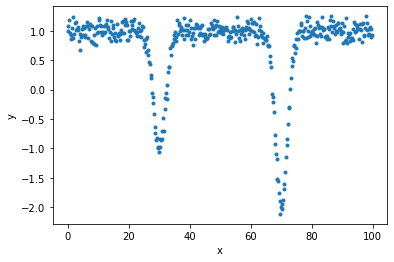

In [5]:
# READ AND PLOT SOME DATA
data0 = ascii.read('PS7_two_gauss.dat')
plt.plot(data0['x'],data0['y'],'.')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [6]:
# TO FIT A FUNCTION TO THE DATA, WE WILL USE SCIPY CURVE_FIT
# WE NEED TO DEFINE THE FUNCTION, PROVIDE DATA AND AN INITIAL GUESS

# MY INITIAL GUESS LOOKING AT THE PLOT ABOVE
p_init=[2,30,1,3,70,1,1]

# RUN CURVE_FIT
p, pcov = curve_fit(gaussian_twopeaks, data0['x'], data0['y'], p0=p_init)    
pcov # diagonal array shows error

array([[ 1.04641082e-03, -1.52419269e-10,  6.68981765e-04,
         1.57920484e-05,  3.29581630e-14, -2.05537171e-05,
        -2.23333292e-05],
       [-1.52419269e-10,  1.43128614e-03, -1.54732642e-10,
        -3.38525415e-14, -7.06579642e-23,  4.40598722e-14,
         4.78747275e-14],
       [ 6.68981765e-04, -1.54732642e-10,  1.49708044e-03,
        -3.22339341e-05, -6.72723863e-14,  4.19532124e-05,
         4.55856669e-05],
       [ 1.57920484e-05, -3.38525415e-14, -3.22339341e-05,
         1.09061028e-03, -2.47930058e-10,  4.45746558e-04,
        -2.23333292e-05],
       [ 3.29581630e-14, -7.06579642e-23, -6.72723863e-14,
        -2.47930058e-10,  6.06900611e-04, -1.61897643e-10,
        -4.66098554e-14],
       [-2.05537171e-05,  4.40598722e-14,  4.19532124e-05,
         4.45746558e-04, -1.61897643e-10,  6.33651750e-04,
         2.90673457e-05],
       [-2.23333292e-05,  4.78747275e-14,  4.55856669e-05,
        -2.23333292e-05, -4.66098554e-14,  2.90673457e-05,
         3.1584097

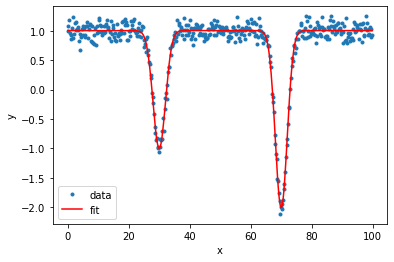

In [7]:
# USE THE SAME FUNCTION TO GENERATE A FIT
fit0 = gaussian_twopeaks(data0['x'],*p)

# AND OVERPLOT RESULTS
plt.plot(data0['x'],data0['y'],'.',label='data')
plt.plot(data0['x'],fit0,'r-',label='fit')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [8]:
# OUTPUT IS CONTAINED IN P
# FANCY PRINT STATEMENT
print('For first peak:')
print('Peak height above background = {:0.2f}'.format(p[0]))
print('Central value                = {:0.2f}'.format(p[1]))
print('One Sigma                    = {:0.2f}'.format(p[2]))
print('For second peak:')
print('Peak height above background = {:0.2f}'.format(p[3]))
print('Central value                = {:0.2f}'.format(p[4]))
print('One Sigma                    = {:0.2f}'.format(p[5]))
print('Background                   = {:0.2f}'.format(p[6]))

For first peak:
Peak height above background = -2.00
Central value                = 29.99
One Sigma                    = 2.04
For second peak:
Peak height above background = -3.01
Central value                = 69.99
One Sigma                    = 1.96
Background                   = 1.00


## Seeing + Photometry

2. Measure the seeing

In [9]:
def show_picture(data):
    """Shows a picture between 1st and 99th percentiles of 
    input data set, using plt
    For debugging, if area selected does not have well defined star"""
    fig = plt.figure(figsize = (5, 5))
    plt.imshow(data, origin = 'lower', cmap = 'gray_r')
    plt.axis('off')
    plt.colorbar()
    plt.show()
    return

In [10]:
# automatic version

def extract_star(data, x_min, y_min):
    # Code to extract a 20 pixel x 20 pixel box from data array
    # Input x_min, y_min corner coordinates    
    box_image = []
    for row_idx in range(len(data)):
        if row_idx >= y_min and row_idx <= (y_min+20):
            box_image.append(data[row_idx][x_min:x_min+19])
    #show_picture(box_image)
    return box_image

def collapse_star(star_array):
    # Sums pixels along horizontal direction
    # Returns array of [[x coordinates],[sum outputs]]
    sum_output = []
    row_count = []
    for row_idx in range(len(star_array)):
        sum_output.append(sum(star_array[row_idx]))
        row_count.append(row_idx)
    return [row_count, sum_output]

def gaussian_fitstar(star_input, p_init):
    # conduct Gaussian fit and return one sigma value
    # star_input is array of arrays, [[x coordinates],[sum outputs]]
    plt.plot(star_input[0],star_input[1],'.')
   
    p, pcov = curve_fit(gaussian_onepeak,star_input[0],star_input[1], p0=p_init)    
    fit = gaussian_onepeak(star_input[0],*p)

    plt.plot(star_input[0],star_input[1],'.',label='data')
    plt.plot(star_input[0],star_input[1],fit,'r-',label='fit')
    plt.legend()
    plt.show()

    print('Peak height above background = {:0.2f}'.format(p[0]))
    print('Central value                = {:0.2f}'.format(p[1]))
    print('One Sigma                    = {:0.2f}'.format(p[2]))
    print('Background                   = {:0.2f}'.format(p[3]))
    return p[2]


def measure_seeing(file_name):
    # Code to automate calculation of seeing effect
    # file_name is string of FITS file to open
    # Compiles seeing from three stars selected in DS9
    one_sigmas = []   # output values
    this_science = fits.open(file_name)    
    data_science = this_science[0].data.copy()

    # First star
    box_image1 = extract_star(data_science, 132, 1225)
    star1 = collapse_star(box_image1)
    p_init=[20000,10,5,10]
    one_sigmas.append(gaussian_fitstar(star1, p_init))
    show_picture(box_image1) # for reference
    
    # Second star
    box_image2 = extract_star(data_science, 145, 1195)
    star2 = collapse_star(box_image2)
    p_init2=[20000,10,5,10]
    one_sigmas.append(gaussian_fitstar(star2, p_init2))

    # Third star
    box_image3 = extract_star(data_science, 200, 1078)
    star3 = collapse_star(box_image3)
    #show_picture(box_image3)
    p_init3=[20000,10,5,10]
    one_sigmas.append(gaussian_fitstar(star3, p_init3))
    
    return one_sigmas

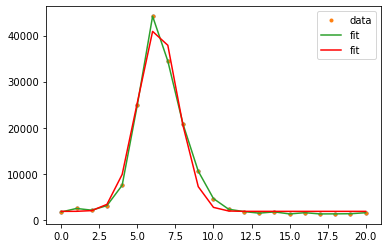

Peak height above background = 40579.85
Central value                = 6.36
One Sigma                    = 1.31
Background                   = 1845.99


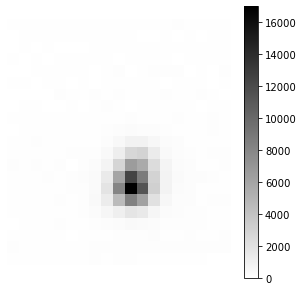

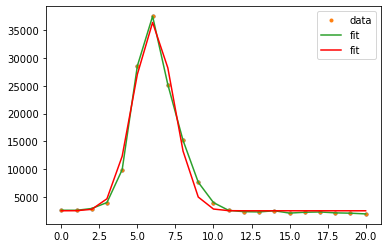

Peak height above background = 33894.81
Central value                = 6.04
One Sigma                    = 1.29
Background                   = 2508.15


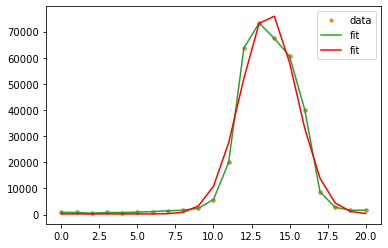

Peak height above background = 77264.12
Central value                = 13.62
One Sigma                    = 1.81
Background                   = 275.92


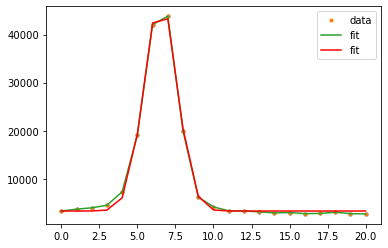

Peak height above background = 44097.65
Central value                = 6.52
One Sigma                    = -1.07
Background                   = 3306.93


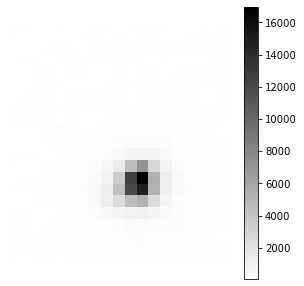

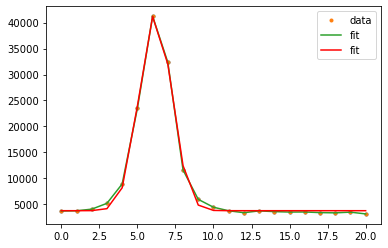

Peak height above background = 38006.28
Central value                = 6.19
One Sigma                    = 1.05
Background                   = 3771.36


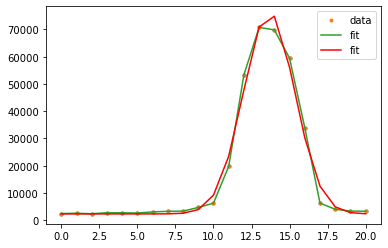

Peak height above background = 73997.92
Central value                = 13.66
One Sigma                    = 1.68
Background                   = 2349.69
Peak height above background = -2.00


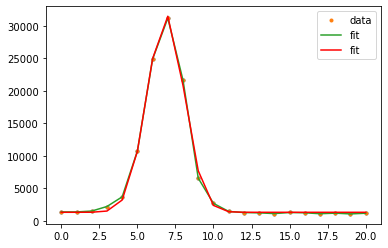

Peak height above background = 30334.28
Central value                = 6.86
One Sigma                    = 1.21
Background                   = 1332.89


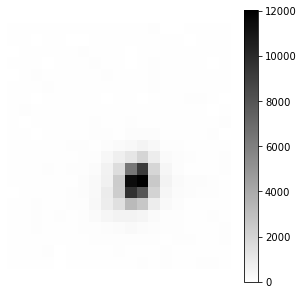

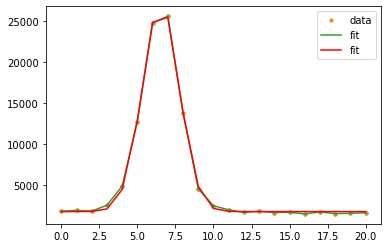

Peak height above background = 25485.79
Central value                = 6.54
One Sigma                    = 1.20
Background                   = 1762.62


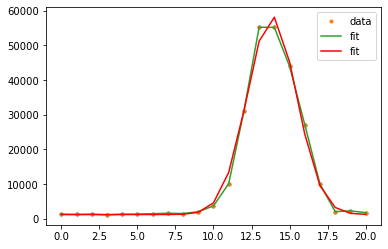

Peak height above background = 57196.74
Central value                = 13.84
One Sigma                    = 1.61
Background                   = 1199.88


In [11]:
one_sigmas1 = measure_seeing("newscience1.fits")
one_sigmas2 = measure_seeing("newscience2.fits")
print('Peak height above background = {:0.2f}'.format(p[0]))

one_sigmas3 = measure_seeing("newscience3.fits")

In [12]:
print('One-sigma seeing from 1st science image = {:0.3f},\
{:0.3f},{:0.3f}'.format(one_sigmas1[0],one_sigmas1[1],one_sigmas1[2]))

print('One-sigma seeing from 2nd science image = {:0.3f},\
{:0.3f},{:0.3f}'.format(one_sigmas2[0],one_sigmas2[1],one_sigmas2[2]))

print('One-sigma seeing from 3rd science image = {:0.3f},\
{:0.3f},{:0.3f}'.format(one_sigmas3[0],one_sigmas3[1],one_sigmas3[2]))

One-sigma seeing from 1st science image = 1.311,1.294,1.814
One-sigma seeing from 2nd science image = -1.071,1.054,1.678
One-sigma seeing from 3rd science image = 1.212,1.196,1.610


Using the telescope CCD specification of 0.88" per pixel, these seeing values correspond to 1-2" values as expected for ground-based images. Between exposures, the seeing did not change significantly. There is one anomalous fit sigma at -1.071 pixel for the 2nd image, possible due to the limited number of pixel input. 

#### Bonus

In [13]:
## Bonus 1; open science 1 fits

def extract_fine(data, x_min, y_min):
    # Code to extract a 10 pixel x 10 pixel box from data array
    # Input x_min, y_min corner coordinates    
    box_image = []
    for row_idx in range(len(data)):
        if row_idx >= y_min and row_idx <= (y_min+10):
            box_image.append(data[row_idx][x_min:x_min+9])
    #show_picture(box_image)
    return box_image

moving_science = fits.open("newscience1.fits")    
data_moving = moving_science[0].data.copy()

# Moon is in box [223->231, 1192->1201]
box_imageMoon = extract_fine(data_moving, 223, 1192)
moonArray = collapse_star(box_imageMoon)
moonSum = 0
for value in moonArray[1]:
    moonSum += value
moonMag = -2.5*np.log10(moonSum)
print('Apparent magnitude of moon Triton: {:0.5f}'.format(moonMag))

# convert to absolute magnitude
moon_absMag = moonMag - 5*np.log10(17.783/206265/10) 
print('Absolute magnitude of moon Triton: {:0.5f}'.format(moon_absMag))


# Asteroid is in box [465->464, 1135->1144]
box_imageAstr = extract_fine(data_moving, 465, 1135)
astrArray = collapse_star(box_imageAstr)
astrSum = 0
for value in astrArray[1]:
    if value >= 0:
        astrSum += value   
astrMag = -2.5*np.log10(astrSum)
print('Apparent magnitude of asteroid: {:0.5f}'.format(astrMag))

astr_absMag = astrMag - 5*np.log10(38.898/206265/10) 
print('Absolute magnitude of asteroid: {:0.5f}'.format(astr_absMag))


# FLUX AND LUM RATIO
flux_ratio = 10**(0.4*(moonMag-astrMag))
lum_ratio = 10**(0.4*(moon_absMag-astr_absMag))
print()
print('The flux ratio is {:0.5f}'.format(flux_ratio))
print('The luminosity ratio is {:0.5f}'.format(lum_ratio))

Apparent magnitude of moon Triton: -14.80848
Absolute magnitude of moon Triton: 10.51362
Apparent magnitude of asteroid: -6.64945
Absolute magnitude of asteroid: 16.97304

The flux ratio is 0.00054
The luminosity ratio is 0.00261


## Spectroscopy

4. Opening PS7_spectrum.dat data

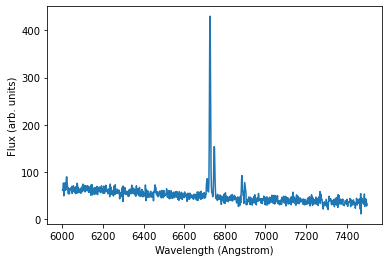

  wave     flux       ivar   
------- --------- -----------
6000.68 60.708486  0.00113257
6002.21 60.888725  0.00111129
6003.73 63.770838  0.00113715
6005.26 76.079142  0.00114163
6006.78 48.868617  0.00115189
6008.31  62.31975  0.00120292
6009.83 67.955506  0.00115476
6011.36 60.781379  0.00117287
6012.89 76.587096  0.00119169
6014.41 60.850435  0.00116796
    ...       ...         ...
7484.13 31.192255 0.000993378
7485.67  41.93294  0.00123591
7487.21 52.582294  0.00143285
7488.75 26.450737  0.00153245
7490.29  27.90758  0.00139335
7491.83 42.686349  0.00134466
7493.38  31.69848  0.00142344
7494.92 41.554847  0.00150352
7496.46 41.205885  0.00161654
 7498.0 27.219792  0.00157768
7499.54 31.559711  0.00156148
Length = 978 rows


In [14]:
data1 = ascii.read('PS7_spectrum.dat')
plt.plot(data1['wave'],data1['flux'],'-',label='data')
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux (arb. units)")
plt.show()

print(data1)

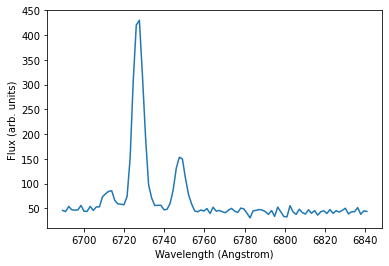

In [15]:
# PLOT DATA IN MODIFIED RANGE
spec_data = data1[450:550]
plt.plot(spec_data['wave'],spec_data['flux'],'-',label='data')
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux (arb. units)")
plt.show()

5. Measure the center of an emission line

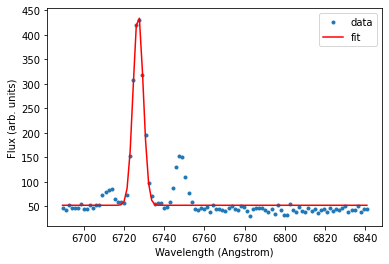

For first peak:
Peak height above background = 393.28
Central value                = 6726.90
One Sigma                    = 2.50
Background                   = 52.30

The center of the emission line is 6726.90 Ang


In [16]:
# SINGLE FIT CASE 
p_init =[375,6725,2,50]
p2, pcov = curve_fit(gaussian_onepeak, spec_data['wave'],spec_data['flux'], p0=p_init)    

fit = gaussian_onepeak(spec_data['wave'],*p2)

plt.plot(spec_data['wave'],spec_data['flux'],'.',label='data')
plt.plot(spec_data['wave'],fit,'r-',label='fit')
plt.legend()
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux (arb. units)")
plt.show()

# OUTPUT IS CONTAINED IN P
# FANCY PRINT STATEMENT
print('For first peak:')
print('Peak height above background = {:0.2f}'.format(p2[0]))
print('Central value                = {:0.2f}'.format(p2[1]))
print('One Sigma                    = {:0.2f}'.format(p2[2]))
print('Background                   = {:0.2f}'.format(p2[3]))
print()
print("The center of the emission line is {:0.2f} Ang".format(p2[1]))

In [17]:
# Brightest line central wavelength is 6712.24 Ang; originally 6562 Ang

velocity = (6712.24-6562)/6562*3*10**5   # in km/s
redshift = (6712.24-6562)/6562

# Hubble's Law: v = H_0 * D where H_0 is 70 km/s /Mpc
distance = 70/velocity

print('The velocity is {:0.3f} km/s'.format(velocity))
print('The redshift z is {:0.3f}'.format(redshift))
print('The distance is Mpc is {:0.3f}'.format(distance))

The velocity is 6868.638 km/s
The redshift z is 0.023
The distance is Mpc is 0.010


#### Bonus three peak fitting

In [18]:
# three peak fits
def gaussian_threepeaks(x,*p):
    # Two gaussian peaks with:
    #(1)Peak height above background : p[0]
    #   Central value                : p[1]
    #   Standard deviation           : p[2]
    #(2)Peak height above background : p[3]
    #   Central value                : p[4]
    #   Standard deviation           : p[5]
    #(3)Peak height above background : p[6]
    #   Central value                : p[7]
    #   Standard deviation           : p[8]
    #   Background                   : p[9]
    # Includes some background level
    
    peak1 = p[0]*np.exp(-1.*(x-p[1])**2/(2.*p[2]**2))
    peak2 = p[3]*np.exp(-1.*(x-p[4])**2/(2.*p[5]**2))
    peak3 = p[6]*np.exp(-1.*(x-p[7])**2/(2.*p[8]**2))

    return peak1+peak2+peak3+p[9]


# MY INITIAL GUESS LOOKING AT THE PLOT ABOVE
p_init2 =[30,6715,1,375,6725,1,100,6750,1,50]

# RUN CURVE_FIT
p2, pcov2 = curve_fit(gaussian_threepeaks, spec_data['wave'],spec_data['flux'], p0=p_init2)    
#pcov2 # diagonal array shows error

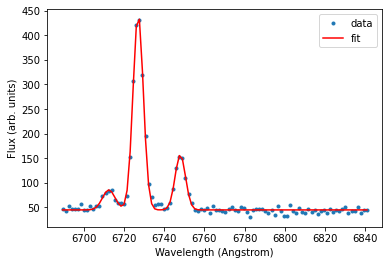

For first peak:
Peak height above background = 40.75
Central value                = 6712.24
One Sigma                    = 3.14
For second peak:
Peak height above background = 398.83
Central value                = 6726.90
One Sigma                    = 2.57
For third peak:
Peak height above background = 112.37
Central value                = 6747.94
One Sigma                    = 2.59
Background                   = 44.81


In [19]:
# USE THE SAME FUNCTION TO GENERATE A FIT
fit2 = gaussian_threepeaks(spec_data['wave'],*p2)

# AND OVERPLOT RESULTS
plt.plot(spec_data['wave'],spec_data['flux'],'.',label='data')
plt.plot(spec_data['wave'],fit2,'r-',label='fit')
plt.legend()
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux (arb. units)")
plt.show()

# OUTPUT IS CONTAINED IN P
# FANCY PRINT STATEMENT
print('For first peak:')
print('Peak height above background = {:0.2f}'.format(p2[0]))
print('Central value                = {:0.2f}'.format(p2[1]))
print('One Sigma                    = {:0.2f}'.format(p2[2]))
print('For second peak:')
print('Peak height above background = {:0.2f}'.format(p2[3]))
print('Central value                = {:0.2f}'.format(p2[4]))
print('One Sigma                    = {:0.2f}'.format(p2[5]))
print('For third peak:')
print('Peak height above background = {:0.2f}'.format(p2[6]))
print('Central value                = {:0.2f}'.format(p2[7]))
print('One Sigma                    = {:0.2f}'.format(p2[8]))
print('Background                   = {:0.2f}'.format(p2[9]))

In [2]:
# Brightest line central wavelength is 6726.90 Ang; originally 6562 Ang

velocity = (6726.90-6562)/6562*3*10**5   # in km/s
redshift = (6726.90-6562)/6562

# Hubble's Law: v = H_0 * D where H_0 is 70 km/s /Mpc
distance = velocity/70

print('The velocity is {:0.3f} km/s'.format(velocity))
print('The redshift z is {:0.3f}'.format(redshift))
print('The distance is Mpc is {:0.5f}'.format(distance))

The velocity is 7538.860 km/s
The redshift z is 0.025
The distance is Mpc is 107.69800


There is a slight change from 6712.24 Ang to 6726.90 Ang after fitting three peaks, but this is not a significant difference. 


## Telescope proposal

### From Problem Set 4

Recent observations of Saturn and Jupiter aurorae, from the Cassini spacecraft and Keck Observatory respectively, have generated heat maps suggesting the hot aurorae are responsible for the high temperatures of the gas giant planets. The question of why Jupiter and Saturn are hot, instead of freezing cold, has perplexed astronomers since the first temperature measurements by Voyager. Thus, it may be possible to conduct further ground based studies in the near infrared spectrum to create more comprehensive mappings of Jupiter and Saturn, conducted over multiple nights. 

### Additional science

Auroras require a source of energetic particles, a magnetic field and an atmosphere. Like Earth, Jupiter and Saturn have these components but generate aurorae quite differently; without liquid-iron cores, the ice planets have liquid hydrogen cores instead due to their large masses and volumes. Furthermore, instead of solar wind, the ice planets rely on moons' volanic activity to generate energetic particles (Jupiter from Io, and Saturn from Enceladus).

The observations requested are ground based telescope like the Keck Observatory in wavelength range of between 350 and 560 nm, from the UV to visible light; observation duration will be long (~ 5 hours per night) in order to get a full snapshot of Jupiter and Saturn at that time, to track any thermal structures.  


Paper referenced: J. O’Donoghue, L. Moore, T. Bhakyapailbul, H. Melin, T. Stallard, J. E. P. Connerney and C. Tao. Global upper-atmospheric heating on Jupiter by the polar aurorae. (2021) Nature, 596, 54-57. 
